# 키워드 입력해서 리뷰가 가장 비슷한 책 찾기

## 설치

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## 폰트 설치

In [34]:
import matplotlib.font_manager as fm
# 한글 폰트 설정
all_fonts = fm.findSystemFonts(fontpaths=None, fontext="ttf")

# "Nanum"으로 시작하는 폰트 찾기
nanum_fonts = [font for font in all_fonts if "Nanum" in font]

# 폰트 설정
if len(nanum_fonts) > 0:
    font_name = fm.FontProperties(fname=nanum_fonts[1]).get_name()
    plt.rcParams["font.family"] = font_name
else:
    print("Nanum으로 시작하는 폰트가 설치되지 않았습니다.")

## 코사인 유사도 계산으로 키워드와 유사한 리뷰가 많은 Top3 찾기

In [ ]:
# 키워드 입력 받기
keywords_input = input("원하는 리뷰 키워드를 입력하고 엔터를 눌러주세요(여러개 입력 시 ',' 으로 구분해주세요): ")
keywords = keywords_input.split(',')

#리뷰 데이터 로드
data = pd.read_csv('all_reviews_filtered_utf8.csv')
# sklearn의 TF-IDF 벡터라이저와 코사인 유사도를 활용하여 키워드와 리뷰 간의 유사성을 계산합니다.
# 각 리뷰와 키워드의 TF-IDF 벡터를 계산하여 코사인 유사도를 계산합니다.

# NaN 값을 빈 문자열로 대체
data['comment'] = data['comment'].fillna("")

# 단어들을 하나의 문자열로 합침
keywords_string = " ".join(keywords)

# 데이터프레임에 새로운 행 추가, 모든 컬럼에 대해 값을 설정
data.loc[len(data)] = [None, None, None, None, keywords_string, None, None]

# TF-IDF 벡터화 도구 초기화
tfidf_vectorizer = TfidfVectorizer()

# 리뷰 코멘트와 키워드를 TF-IDF 벡터로 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(data['comment'])

# 마지막 벡터(결합된 키워드)와 모든 리뷰 벡터 간의 코사인 유사도 계산
cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1]).flatten()

# 유사도 점수를 데이터프레임에 할당 (이전에 존재하지 않는 'similarity_score' 컬럼이 추가됩니다)
data['similarity_score'] = np.append(cosine_similarities, 0)  # 마지막 행에는 0을 할당합니다.

# 책 제목별로 그룹화하고 유사도 점수 합산 (마지막 행은 제외합니다.)
similarity_scores_sum = data.iloc[:-1].groupby('title')['similarity_score'].sum()

# 유사도 점수를 기준으로 책 정렬
sorted_books_by_similarity = similarity_scores_sum.sort_values(ascending=False).head(3)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_books_by_similarity.values, y=sorted_books_by_similarity.index)
plt.title('키워드와 유사도 높은 리뷰가 많은 책 Top3')
plt.xlabel('전체 유사도 점수')
plt.ylabel('제목')
plt.show()

## 각 책 당 유사한 리뷰 5개 추출

In [44]:
# 상위 3권의 책 제목을 추출
top_3_books_titles = sorted_books_by_similarity.index[:3]

# 각 책별로 유사도 점수가 높은 상위 10개의 리뷰를 선택
top_reviews_per_book_expanded = data.sort_values(by='similarity_score', ascending=False).groupby('title').head(10)

# 상위 3권의 책에 대한 유사한 리뷰를 선택
top_reviews_for_top_books_expanded = top_reviews_per_book_expanded[top_reviews_per_book_expanded['title'].isin(top_3_books_titles)]

# 결과 출력을 위해 책 제목별로 리뷰를 그룹화
grouped_reviews_expanded = top_reviews_for_top_books_expanded.groupby('title')['comment'].apply(list)

# 각 리뷰 코멘트를 쉼표(,) 기준으로 한 줄씩 출력하되, 각 타이틀당 최대 10개의 리뷰만 출력
for title, comments in grouped_reviews_expanded.items():
    print(f'{title}\n{"-" * len(title)}')
    
    # 쉼표로 구분된 리뷰를 분리하고, 최대 5개까지만 가져옵니다.
    comments_list = comments[:5]
    
    # 각 리뷰 앞에 순서 번호를 붙여서 출력합니다.
    for idx, comment in enumerate(comments_list, 1):
        print(f'{idx}. {comment}')
    
    print("\n")  # 제목별로 구분을 위해 추가된 빈 줄

나미야 잡화점의 기적 (양장)
----------------
1. 감동적이다
2. 감동적이다
3. 주변 모두에게 선물하고 추천하고 싶은 책따뜻하고 재미있고 감동적이다
4. 재미있다 그리고 감동적이다 히가시노 게이고의 기존 추리와는 완전 다른 형식이다훈훈한 이야기로 꽉 차 있다 선물용으로 좋다
5. 최고다 아주 유쾌하고 감동적이다 나를 다시 독서하도록 이끌어준 아주 고마운 책이고 꼭 나중에 다시 읽어보고 싶다 많은 사람들에게 추천해주고싶은 책 남녀노소 구별없이 모든 이들이 좋아할 것 같다 그리고 이 작가의 다른 책들을 궁금하게만들었다


마션
--
1. 감동적이다
2. 완전 감동적이다
3. 감동적이다 영화도 책도
4. 영화만큼 감동적이다
5. 포기하지 않은 모습에 감동적이다


오베라는 남자
-------
1. 감동적이다
2. 감동적이다
3. 따뜻한 책이고 감동적이다
4. 재미있고 따뜻하며 감동적이다
5. 재미있고 따뜻하며 감동적이다




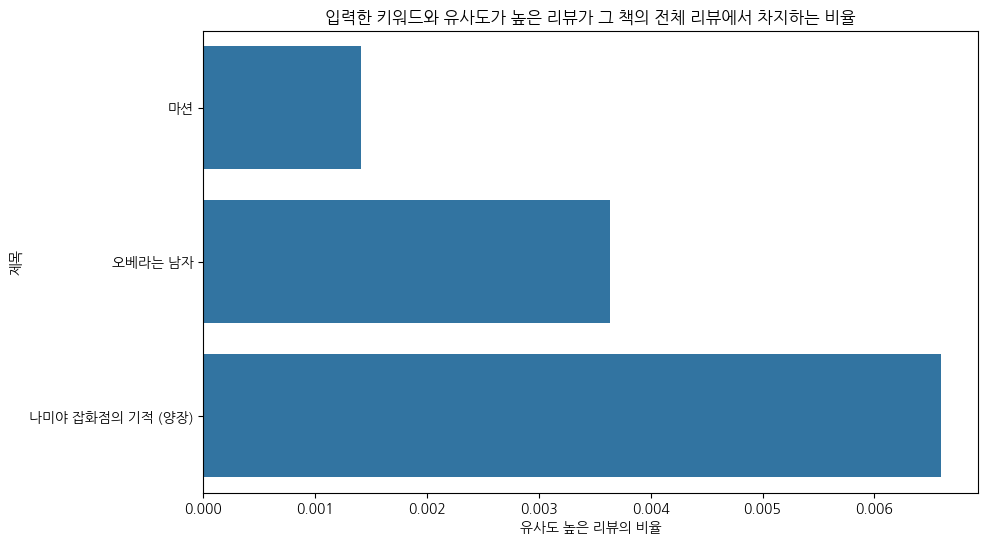

In [48]:
# 유사도 점수의 75번째 백분위수를 기준으로 설정 (유사도가 높은 리뷰를 식별하기 위한 기준)
threshold = np.percentile(data['similarity_score'], 75)

# 유사도가 높은 리뷰들만 필터링
high_similarity_reviews = data[data['similarity_score'] > threshold]

# 각 책별로 유사도가 높은 리뷰의 개수 계산
high_similarity_counts = high_similarity_reviews.groupby('title').size()

# 각 책별 전체 리뷰 개수 계산 (마지막에 추가된 키워드 행은 제외)
total_review_counts = data.iloc[:-1].groupby('title').size()

# 유사도가 높은 리뷰의 비율 계산
similarity_ratio = high_similarity_counts / total_review_counts

# Top 3 책 필터링
top_3_books = sorted_books_by_similarity.index[:3]

# Top 3 책의 유사도 비율 선택
top_3_similarity_ratio = similarity_ratio[top_3_books]

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=top_3_similarity_ratio.values, y=top_3_similarity_ratio.index)
plt.title('입력한 키워드와 유사도가 높은 리뷰가 그 책의 전체 리뷰에서 차지하는 비율')
plt.xlabel('유사도 높은 리뷰의 비율')
plt.ylabel('제목')
plt.show()